In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

from itertools import chain 

Welcome to JupyROOT 6.22/02
3.6.8 (default, Apr  2 2020, 13:34:55) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
 

# 
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/2018_sigmatch/dnn_v3_0lep_1lep_roc/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/2018_sigmatch/dnn_v3_miniAOD_0lep_1lep_roc/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/2018_sigmatch/debug_dnn_v3_miniAOD_roc/'
# 
os.system("mkdir -p "+ plotDir)

0

In [3]:
# std_color_list = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36]
std_color_list_ext = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36, 221, 205, 209, 216, 213, 52, 148]


# ALL BKG TAG EFF

In [4]:
tags = []
tags = [
    
#         'H(bb)H(bb), 400 GeV, 1 GeV, 1 m',
        'H(bb)H(bb), 200 GeV, 1 GeV, 1 m',
#         'QCD_HT_all, background',
#         'WLNu_HT_all, background',
#         'ZNunu_HT_all, background',
#         'TT_Lep, background',

        'Data 2018',
    
#         'WLNu_HT_bin, background',
#         'WLNu_no_bin, background',
    
        ]


# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/'
# file names

fnames = {}

# fnames['H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = 'V1p17/v24/MC_Fall18/1pb_normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'
# fnames['H(bb)H(bb), 400 GeV, 1 GeV, 1 m'] = 'V1p17/v24/MC_Fall18/1pb_normalized/TChiHH_mass400_pl1000_1pb_weighted.root'
fnames['H(bb)H(bb), 400 GeV, 1 GeV, 1 m'] = 'V1p17/v29/MC_Fall18/normalized/TChiHH_mass400_pl1000_1pb_weighted.root'
fnames['H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = 'V1p17/v29/MC_Fall18/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'
fnames['QCD_HT_all, background'] = 'V1p17/v28/MC_Fall18/normalized/QCD_HT50toInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['WLNu_HT_all, background'] = 'V1p17/v28/MC_Fall18/normalized/WJetsToLNu_HT-70ToInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['ZNunu_HT_all, background'] = 'V1p17/v28/MC_Fall18/normalized/ZJetsToNuNu_HT-100ToInf_13TeV-madgraph_1pb_weighted.root'
fnames['TT_Lep, background'] = 'V1p17/v28/MC_Fall18/normalized/TTJets_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['Data 2018'] = 'V1p17/v29/Data2018/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-HighMET-17Sept2018_GoodLumi.root'

fnames['WLNu_HT_bin, background'] = 'V1p17/v24/MC_Fall18/normalized/output_wjet_htbinned.root'
fnames['WLNu_no_bin, background'] = 'V1p17/v24/MC_Fall18/normalized/output_wjet_nobinned.root'

# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])

    root_dir = uproot.open(home_dir+fnames[tag])
    tree[tag] = root_dir['SusyLLPTree']

    print ('Open ready')
    print(tag)
    print ('Tree ready')
    print(tree[tag], tree)
    v = tree[tag]
    jet_amax = v['jetGammaMax_ET'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    print(np.unique(jet_amax))
     


/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v29/MC_Fall18/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root
Open ready
H(bb)H(bb), 200 GeV, 1 GeV, 1 m
Tree ready
<TTree b'SusyLLPTree' at 0x7fcbf0d412b0> OrderedDict([('H(bb)H(bb), 200 GeV, 1 GeV, 1 m', <TTree b'SusyLLPTree' at 0x7fcbf0d412b0>)])
[[0.0061251214 0.7019389] [0.0028977073 0.4111059 0.3840051] [0.005129548] ... [0.015017021] [0.0] [0.63470644 0.02270847]]
[1.6096239e-05 1.6096239e-05 1.6096239e-05 1.6096239e-05 1.6096239e-05
 1.6096239e-05 1.6096239e-05 1.6096239e-05 1.6096239e-05 1.6096239e-05]
[1.6096239e-05]
/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v29/Data2018/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-HighMET-17Sept2018_GoodLumi.root
Open ready
Data 2018
Tree ready
<TTree b'SusyLLPTree' at 0x7fcbf0ae8470> OrderedDict([('H(bb)H(bb), 200 GeV, 1 GeV, 1 m', <TTree b'SusyLLPTree' at 0x7fcbf0d412b0>), ('Data 201

# Test/Debug Plot

In [5]:
# trg_path=310
trg_path=467
njet_cut=-1
met_cut=200
mt_cut=100
ht_cut=100
mdphi_cut=0.5
veto=1

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
# fatjet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6

trg_0lep_w = {} 
trg_0lep_puw = {} 
trg_0lep_dnnv3 = {}
trg_0lep_dnnv3mini = {}
trg_0lep_pt = {}

trg_1lep_w = {} 
trg_1lep_puw = {} 
trg_1lep_dnnv3 = {}
trg_1lep_dnnv3mini = {}
trg_1lep_pt = {}


for k,v in tree.items():
    print(k,v)

    # branches
    evt = v['evtNum'].array()
    met = v['met'].array()
    mt = v['MT'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    nhcalhit = v['jetNRecHitsHcal'].array()
    hcalt = v['jetTimeRecHitsHcal'].array()
    
    #jet var
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    
    muef = v['jetMuonEnergyFraction'].array()

    
    csv = v['jetCSV'].array()
    
    dnnv1 = v['jetDNNScoreV1'].array()
    dnnv3 = v['jetDNNScoreV3'].array()
    dnnv3miniAOD = v['jetDNNScoreV3miniAOD'].array()
    dnn = v['jetDNNScore'].array()
    

    chm = v['jetChargedMultiplicity'].array()
    nseltrk = v['jetNSelectedTracks'].array()
    time = v['jetTime'].array()
    ecale = v['jetEnergyRecHitsEcal'].array()
    nhits = v['jetNRecHitsEcal'].array()
    chef = v['jetChargedHadronEnergyFraction'].array()
#     nhef = v['jetNeutalHadronEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    alltrkpt = v['jetPtAllTracks'].array()
    pvtrkpt = v['jetPtAllPVTracks'].array()
    amax = v['jetAlphaMax'].array()
    bmax = v['jetBetaMax'].array()
    gmax = v['jetGammaMax'].array()
    gmaxem = v['jetGammaMax_EM'].array()
    gmaxh = v['jetGammaMax_Hadronic'].array()
    tmf = v['jetGammaMax_ET'].array()
    drall = v['jetMinDeltaRAllTracks'].array()
    dr = v['jetMinDeltaRPVTracks'].array()

    weight = v['weight'].array()
    
    #pileup weights
    if 'background' in k:
        PUweight = v['pileupWeight'].array()
        
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)
        


    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, ht>ht_cut)

    if 'background' in k:
        basic_met_str = np.logical_and(basic_met_str, evt%2==1)
        
    
    if veto==1:
#         basic_met_str = np.logical_and(basic_met_str, nmu==0)
#         basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut) 
#     basic_jet_str = np.logical_and(basic_jet_str, nhcalhit>0)   
#     basic_jet_str = np.logical_and(basic_jet_str, hcalt>-100)   

    # matched requirement
    if 'bb' in k:
        matched0 = v['jet_matched_gLLP0_grandaughter'].array()
        matched1 = v['jet_matched_gLLP1_grandaughter'].array()

        matched_str = np.logical_or(matched0==1, matched1==1)
        
        acc0_eb = v['gLLP0_EB'].array()
        acc1_eb = v['gLLP1_EB'].array()

        acc_eb_str = np.logical_or(acc0_eb==1, acc1_eb==1)
        
        basic_met_str = np.logical_and(basic_met_str, acc_eb_str)

        basic_jet_str = np.logical_and(basic_jet_str, matched_str)

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
#     met_trg_str = np.logical_and(basic_met_str, mdphi>mdphi_cut)
#     met_trg_str = np.logical_and(basic_met_str, mdphi<=mdphi_cut)

    if 'bb' not in k:
        met_1lep_str = np.logical_and(met_trg_str, nlep==1)
        met_0lep_str = np.logical_and(met_trg_str, nlep==0)
    else:
        met_1lep_str = np.logical_and(met_trg_str, 1)
        met_0lep_str = np.logical_and(met_trg_str, 1)
        
#     basic_met_str = np.logical_and(basic_met_str, mt<mt_cut)
    

    # 0lep
    
    #apply sel
    trg_0lep_w[k] = weight[met_0lep_str]
    if 'background' in k:
        trg_0lep_puw[k] = PUweight[met_0lep_str]
    trg_0lep_pt[k] = pt[basic_jet_str][met_0lep_str]
    trg_0lep_dnnv3[k] = dnnv3[basic_jet_str][met_0lep_str]
    trg_0lep_dnnv3mini[k] = dnnv3miniAOD[basic_jet_str][met_0lep_str]

    #clean up
    trg_0lep_w[k] = trg_0lep_w[k][trg_0lep_pt[k].count()>njet_cut]
    if 'background' in k:
        trg_0lep_w[k] = np.array([2*x for x in trg_0lep_w[k]])
    if 'background' in k:
        trg_0lep_puw[k] = trg_0lep_puw[k][trg_0lep_pt[k].count()>njet_cut] 
    trg_0lep_dnnv3[k] = trg_0lep_dnnv3[k][trg_0lep_pt[k].count()>njet_cut]
    trg_0lep_dnnv3mini[k] = trg_0lep_dnnv3mini[k][trg_0lep_pt[k].count()>njet_cut]
    trg_0lep_pt[k] = trg_0lep_pt[k][trg_0lep_pt[k].count()>njet_cut]

    #print out check
    print(len(trg_0lep_w[k]))
    print(len(trg_0lep_pt[k]))

    # 1lep
    
    #apply sel
    trg_1lep_w[k] = weight[met_1lep_str]
    if 'background' in k:
        trg_1lep_puw[k] = PUweight[met_1lep_str]
    trg_1lep_pt[k] = pt[basic_jet_str][met_1lep_str]
    trg_1lep_dnnv3[k] = dnnv3[basic_jet_str][met_1lep_str]
    trg_1lep_dnnv3mini[k] = dnnv3miniAOD[basic_jet_str][met_1lep_str]

    #clean up
    trg_1lep_w[k] = trg_1lep_w[k][trg_1lep_pt[k].count()>njet_cut]
    if 'background' in k:
        trg_1lep_w[k] = np.array([2*x for x in trg_1lep_w[k]])
    if 'background' in k:
        trg_1lep_puw[k] = trg_1lep_puw[k][trg_1lep_pt[k].count()>njet_cut] 
    trg_1lep_dnnv3[k] = trg_1lep_dnnv3[k][trg_1lep_pt[k].count()>njet_cut]
    trg_1lep_dnnv3mini[k] = trg_1lep_dnnv3mini[k][trg_1lep_pt[k].count()>njet_cut]
    trg_1lep_pt[k] = trg_1lep_pt[k][trg_1lep_pt[k].count()>njet_cut]

    #print out check
    print(len(trg_1lep_w[k]))
    print(len(trg_1lep_pt[k]))

    

H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fcbf0d412b0>


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


(1733,)
990
990
990
990
Data 2018 <TTree b'SusyLLPTree' at 0x7fcbf0ae8470>
(8428507,)
6518117
6518117
864460
864460


## DNN DATA V3 0LEP/1LEP

In [6]:
flat_0lep_dnnv3 = {}
flat_0lep_dnnv3mini = {}
flat_1lep_dnnv3 = {}
flat_1lep_dnnv3mini = {}

for k,v in tree.items():
    print(k,v)
    
    flat_0lep_dnnv3[k] = trg_0lep_dnnv3[k].flatten()
    flat_0lep_dnnv3mini[k] = trg_0lep_dnnv3mini[k].flatten()
    flat_1lep_dnnv3[k] = trg_1lep_dnnv3[k].flatten()
    flat_1lep_dnnv3mini[k] = trg_1lep_dnnv3mini[k].flatten()


H(bb)H(bb), 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fcbf0d412b0>
Data 2018 <TTree b'SusyLLPTree' at 0x7fcbf0ae8470>


In [7]:
# 0lep case
# data_cutbase_0lep_eff = 0.000422
# sig200_cutbase_0lep_eff = 0.49863
# sig400_cutbase_0lep_eff = 0.481758
# #1lep case
# data_cutbase_1lep_eff = 0.000343
# sig200_cutbase_1lep_eff = 0.315789
# sig400_cutbase_1lep_eff = 0.464314

In [8]:
wall_0lep = {}
wall_1lep = {}
 
for k,v in tree.items():
    wall_0lep[k] = [np.array([x]*len(y)) for x,y in zip(trg_0lep_w[k],trg_0lep_pt[k])]
    wall_0lep[k] = list(chain.from_iterable(wall_0lep[k])) 
    
    print(len(trg_0lep_w[k]))
    print(len(trg_0lep_pt[k]))
    print(len(wall_0lep[k]))
    
    wall_1lep[k] = [np.array([x]*len(y)) for x,y in zip(trg_1lep_w[k],trg_1lep_pt[k])]
    wall_1lep[k] = list(chain.from_iterable(wall_1lep[k])) 
    
    print(len(trg_1lep_w[k]))
    print(len(trg_1lep_pt[k]))
    print(len(wall_1lep[k]))
    
    

990
990
1089
990
990
1089
6518117
6518117
7179255
864460
864460
1312657


In [9]:
### ROC curve v3

# var = [flat_0lep_dnnv3  ]
# axis = [['jetDNNScoreV3','Events']  ]
# name = ['jetDNNScoreV3'   ]
# bins = [[50,0,1]  ]
# maxs = [1 ]

var = [flat_0lep_dnnv3, flat_0lep_dnnv3mini  ]
axis = [['jetDNNScoreV3','Events'],  ['jetDNNScoreV3miniAOD','Events'] ]
name = ['jetDNNScoreV3', 'jetDNNScoreV3miniAOD'   ]
bins = [[50,0,1],  [50,0,1] ]
maxs = [1, 1 ]
 
Noeffv3_0lep = {}

for i in range(len(var)):
    v = var[i]
    Noeffv3_0lep[name[i]] = {}

    thre = maxs[i]*np.array(range(1,1000))/1000.0
    print(maxs[i],name[i],'thre range',np.max(thre),np.min(thre))
    print(name[i])
    for k in tree.keys():
        v = var[i][k]
        print(k,len(v))
        if len(v)==0:
            print('no')
            Noeffv3_0lep[name[i]][k] = []
            for th in thre:
                Noeffv3_0lep[name[i]][k].append(1.0)
            Noeffv3_0lep[name[i]][k] = np.array(Noeffv3_0lep[name[i]][k])
        else:
            Noeffv3_0lep[name[i]][k] = []
            McSumNum = np.zeros(len(thre))
            for th in thre:
                pass_str = np.logical_and(1, v>th)
                Noeffv3_0lep[name[i]][k].append(1.0*np.sum(np.array(wall_0lep[k])[pass_str])/np.sum(wall_0lep[k]))
            Noeffv3_0lep[name[i]][k] = np.array(Noeffv3_0lep[name[i]][k])
 

1 jetDNNScoreV3 thre range 0.999 0.001
jetDNNScoreV3
H(bb)H(bb), 200 GeV, 1 GeV, 1 m 1089


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


Data 2018 7179255
1 jetDNNScoreV3miniAOD thre range 0.999 0.001
jetDNNScoreV3miniAOD
H(bb)H(bb), 200 GeV, 1 GeV, 1 m 1089
Data 2018 7179255


In [10]:
### ROC curve v3

# var = [flat_1lep_dnnv3  ]
# axis = [['jetDNNScoreV3','Events']  ]
# name = ['jetDNNScoreV3'   ]
# bins = [[50,0,1]  ]
# maxs = [1 ]

var = [flat_1lep_dnnv3, flat_1lep_dnnv3mini  ]
axis = [['jetDNNScoreV3','Events'],  ['jetDNNScoreV3miniAOD','Events'] ]
name = ['jetDNNScoreV3', 'jetDNNScoreV3miniAOD'   ]
bins = [[50,0,1],  [50,0,1] ]
maxs = [1, 1 ]
 
Noeffv3_1lep = {}

for i in range(len(var)):
    v = var[i]
    Noeffv3_1lep[name[i]] = {}

    thre = maxs[i]*np.array(range(1,1000))/1000.0
    print(maxs[i],name[i],'thre range',np.max(thre),np.min(thre))
    print(name[i])
    for k in tree.keys():
        v = var[i][k]
        print(k,len(v))
        if len(v)==0:
            print('no')
            Noeffv3_1lep[name[i]][k] = []
            for th in thre:
                Noeffv3_1lep[name[i]][k].append(1.0)
            Noeffv3_1lep[name[i]][k] = np.array(Noeffv3_1lep[name[i]][k])
        else:
            Noeffv3_1lep[name[i]][k] = []
            McSumNum = np.zeros(len(thre))
            for th in thre:
                pass_str = np.logical_and(1, v>th)
                Noeffv3_1lep[name[i]][k].append(1.0*np.sum(np.array(wall_1lep[k])[pass_str])/np.sum(wall_1lep[k]))
            Noeffv3_1lep[name[i]][k] = np.array(Noeffv3_1lep[name[i]][k])
 

1 jetDNNScoreV3 thre range 0.999 0.001
jetDNNScoreV3
H(bb)H(bb), 200 GeV, 1 GeV, 1 m 1089


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater


Data 2018 1312657
1 jetDNNScoreV3miniAOD thre range 0.999 0.001
jetDNNScoreV3miniAOD
H(bb)H(bb), 200 GeV, 1 GeV, 1 m 1089
Data 2018 1312657


In [11]:
data_keys = ['Data 2018']
var_keys = ['jetDNNScoreV3', 'jetDNNScoreV3miniAOD']
DataEffv3_0lep = {}
DataEffv3_1lep = {}
for data_k in data_keys:
    print(data_k)
    for var_k in var_keys:
        print(var_k)
        DataEffv3_0lep[var_k] = Noeffv3_0lep[var_k][data_k]
        DataEffv3_1lep[var_k] = Noeffv3_1lep[var_k][data_k]
    

Data 2018
jetDNNScoreV3
jetDNNScoreV3miniAOD


In [12]:
# # define working points v3
# aim_nothre_0lep_cntv3 = 0
# aim_nothre_0lep_ptv3 = 1.
# dis_noeff_0lep_ptv3 = 999

# aim_nothre_1lep_cntv3 = 0
# aim_nothre_1lep_ptv3 = 1.
# dis_noeff_1lep_ptv3 = 999

# cntv3_0lep=0
# for cntv3_0lep,ele_0lep in enumerate(DataEffv3_0lep):
#     this_nodis = abs(ele_0lep-data_cutbase_0lep_eff)
#     if this_nodis<dis_noeff_0lep_ptv3:
#         dis_noeff_0lep_ptv3 = this_nodis
#         aim_nothre_0lep_cntv3 = cntv3_0lep
#         aim_nothre_0lep_ptv3 = thre[cntv3_0lep]

# print(aim_nothre_0lep_cntv3,aim_nothre_0lep_ptv3,dis_noeff_0lep_ptv3)

# cntv3_1lep=0
# for cntv3_1lep,ele_1lep in enumerate(DataEffv3_1lep):
#     this_nodis = abs(ele_1lep-data_cutbase_1lep_eff)
#     if this_nodis<dis_noeff_1lep_ptv3:
#         dis_noeff_1lep_ptv3 = this_nodis
#         aim_nothre_1lep_cntv3 = cntv3_1lep
#         aim_nothre_1lep_ptv3 = thre[cntv3_1lep]

# print(aim_nothre_1lep_cntv3,aim_nothre_1lep_ptv3,dis_noeff_1lep_ptv3)

In [13]:
wp_1 = 0.990
wp_1_cnt = int(wp_1*1000-1)
print(wp_1_cnt)
print(thre[wp_1_cnt])
wp_2 = 0.996
wp_2_cnt = int(wp_2*1000-1)

989
0.99


H(bb)H(bb), 200 GeV, 1 GeV, 1 m jetDNNScoreV3
999
999
[0.60606053] [0.00042929]
[0.53351693] [0.00023526]
[0.60606053] [0.00033672]
[0.53351693] [0.00018817]
H(bb)H(bb), 200 GeV, 1 GeV, 1 m jetDNNScoreV3miniAOD
999
999
[0.66666656] [0.00064213]
[0.60789711] [0.00039475]
[0.66666656] [0.00052184]
[0.60789711] [0.00031768]
H(bb)H(bb), 400 GeV, 1 GeV, 1 m jetDNNScoreV3
999
999
[0.64237239] [0.00042929]
[0.58786252] [0.00023526]
[0.64237239] [0.00033672]
[0.58786252] [0.00018817]
H(bb)H(bb), 400 GeV, 1 GeV, 1 m jetDNNScoreV3miniAOD
999
999
[0.71106578] [0.00064213]
[0.66985585] [0.00039475]
[0.71106578] [0.00052184]
[0.66985585] [0.00031768]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/2018_sigmatch/dnn_v3_miniAOD_0lep_1lep_roc/V3_ROC_DNN_Data_BKG_Sig200GeV_V3.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/2018_sigmatch/dnn_v3_miniAOD_0lep_1lep_roc/V3_ROC_DNN_Data_BKG_Sig200GeV_V3miniAOD.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/2018_sigmatch/dnn_v3_miniAOD_0lep_1lep_roc/V3_ROC_DNN_Data_BKG_Sig400GeV_V3.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/2018_sigmatch/dnn_v3_miniAOD_0lep_1lep_roc/V3_ROC_DNN_Data_BKG_Sig400GeV_V3miniAOD

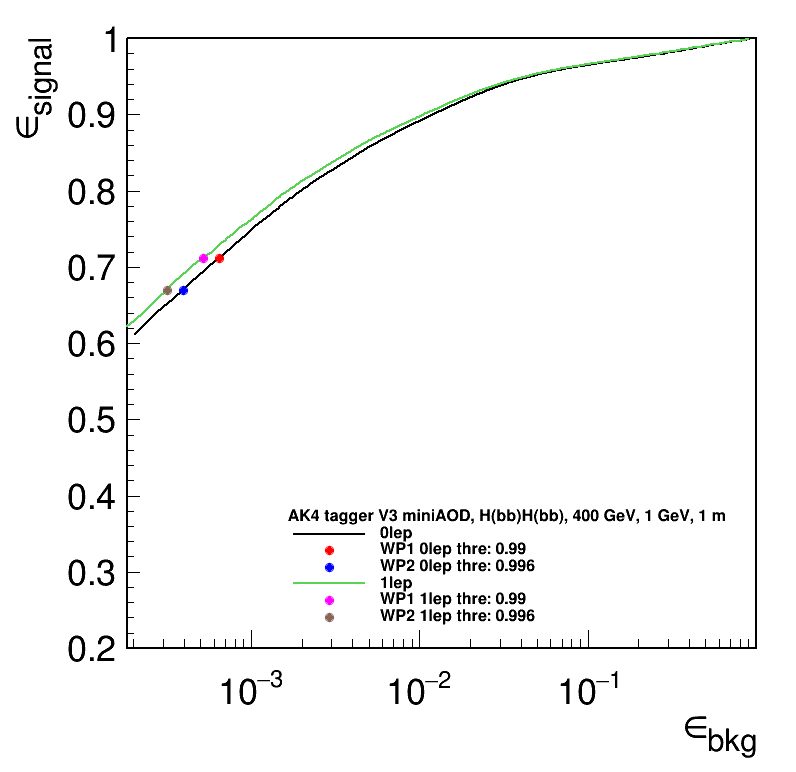

In [32]:
### ROC curve All MC Bkg
 

# sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m',]
minimum_set=0.2
maximum_set=1.0
sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m','H(bb)H(bb), 400 GeV, 1 GeV, 1 m']
var_keys = ['jetDNNScoreV3', 'jetDNNScoreV3miniAOD']
# sig_cutbase_0lep_effs = {}
# sig_cutbase_0lep_effs['H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = sig200_cutbase_0lep_eff
# sig_cutbase_0lep_effs['H(bb)H(bb), 400 GeV, 1 GeV, 1 m'] = sig400_cutbase_0lep_eff
# sig_cutbase_1lep_effs = {}
# sig_cutbase_1lep_effs['H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = sig200_cutbase_1lep_eff
# sig_cutbase_1lep_effs['H(bb)H(bb), 400 GeV, 1 GeV, 1 m'] = sig400_cutbase_1lep_eff

for sig_k in sig_keys:
    for var_k in var_keys:
        i=0
        print(sig_k, var_k)
        print(len(DataEffv3_0lep[var_k]))
        print(len(Noeffv3_0lep[var_k][sig_k]))
        c = rt.TCanvas('c','c', 800, 800)
        leg = rt.TLegend(0.35,0.19,0.86,0.34)
    #     leg = rt.TLegend(0.65,0.19,0.86,0.34)
        leg.SetTextSize(0.022)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        gr = {}
        purity = {}

        #     Plotting ROC curve v3
        gr['Datav3_0lep'+sig_k] = create_TGraph(DataEffv3_0lep[var_k],Noeffv3_0lep[var_k][sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['Datav3_0lep'+sig_k].SetLineColor(std_color_list[i])
        gr['Datav3_0lep'+sig_k].SetLineWidth(2)
        gr['Datav3_0lep'+sig_k].SetMinimum(minimum_set)
        gr['Datav3_0lep'+sig_k].SetMaximum(maximum_set)
        gr['Datav3_0lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['Datav3_0lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)

        gr['Datav3_0lep'+sig_k].Draw('ac' if i==0 else 'c')
#         leg.AddEntry(gr['Datav3_0lep'+sig_k],'DNN V3 0lep, '+sig_k, 'l')
        leg.AddEntry(gr['Datav3_0lep'+sig_k],'0lep', 'l')



        #  working point 1 
        i+=1
        wp1_eff_0lep_sig_pt = np.array([Noeffv3_0lep[var_k][sig_k][wp_1_cnt]]) 
        wp1_eff_0lep_bkg_pt = np.array([DataEffv3_0lep[var_k][wp_1_cnt]]) 
        print(wp1_eff_0lep_sig_pt,wp1_eff_0lep_bkg_pt)
        gr['WP1_0lep'+sig_k] = create_TGraph(wp1_eff_0lep_bkg_pt,wp1_eff_0lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['WP1_0lep'+sig_k].SetMarkerSize(1.)
        gr['WP1_0lep'+sig_k].SetMarkerColor(std_color_list[i])
        gr['WP1_0lep'+sig_k].SetLineColor(std_color_list[i])
        gr['WP1_0lep'+sig_k].SetMinimum(minimum_set)
        gr['WP1_0lep'+sig_k].SetMaximum(maximum_set)
        gr['WP1_0lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['WP1_0lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)


        gr['WP1_0lep'+sig_k].Draw('psame')
        leg.AddEntry(gr['WP1_0lep'+sig_k],'WP1 0lep thre: '+str(wp_1),'p')
        

        #  working point 2 
        i+=1
        wp2_eff_0lep_sig_pt = np.array([Noeffv3_0lep[var_k][sig_k][wp_2_cnt]]) 
        wp2_eff_0lep_bkg_pt = np.array([DataEffv3_0lep[var_k][wp_2_cnt]]) 
        print(wp2_eff_0lep_sig_pt,wp2_eff_0lep_bkg_pt)
        gr['WP2_0lep'+sig_k] = create_TGraph(wp2_eff_0lep_bkg_pt,wp2_eff_0lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['WP2_0lep'+sig_k].SetMarkerSize(1.)
        gr['WP2_0lep'+sig_k].SetMarkerColor(std_color_list[i])
        gr['WP2_0lep'+sig_k].SetLineColor(std_color_list[i])
        gr['WP2_0lep'+sig_k].SetMinimum(minimum_set)
        gr['WP2_0lep'+sig_k].SetMaximum(maximum_set)
        gr['WP2_0lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['WP2_0lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)


        gr['WP2_0lep'+sig_k].Draw('psame')
        leg.AddEntry(gr['WP2_0lep'+sig_k],'WP2 0lep thre: '+str(wp_2),'p')


        #ROC 1lep
        i+=1
        gr['Datav3_1lep'+sig_k] = create_TGraph(DataEffv3_1lep[var_k],Noeffv3_1lep[var_k][sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['Datav3_1lep'+sig_k].SetLineColor(std_color_list[i])
        gr['Datav3_1lep'+sig_k].SetLineWidth(2)
        gr['Datav3_1lep'+sig_k].SetMinimum(minimum_set)
        gr['Datav3_1lep'+sig_k].SetMaximum(maximum_set)
        gr['Datav3_1lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['Datav3_1lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)

        gr['Datav3_1lep'+sig_k].Draw('csame')
#         leg.AddEntry(gr['Datav3_1lep'+sig_k],'DNN V3 1lep, '+sig_k, 'l')
        leg.AddEntry(gr['Datav3_1lep'+sig_k],'1lep ', 'l')


        #  working point 1 
        i+=1
        wp1_eff_1lep_sig_pt = np.array([Noeffv3_1lep[var_k][sig_k][wp_1_cnt]]) 
        wp1_eff_1lep_bkg_pt = np.array([DataEffv3_1lep[var_k][wp_1_cnt]]) 
        print(wp1_eff_1lep_sig_pt,wp1_eff_1lep_bkg_pt)
        gr['WP1_1lep'+sig_k] = create_TGraph(wp1_eff_1lep_bkg_pt,wp1_eff_1lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['WP1_1lep'+sig_k].SetMarkerSize(1.)
        gr['WP1_1lep'+sig_k].SetMarkerColor(std_color_list[i])
        gr['WP1_1lep'+sig_k].SetLineColor(std_color_list[i])
        gr['WP1_1lep'+sig_k].SetMinimum(minimum_set)
        gr['WP1_1lep'+sig_k].SetMaximum(maximum_set)
        gr['WP1_1lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['WP1_1lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)


        gr['WP1_1lep'+sig_k].Draw('psame')
        leg.AddEntry(gr['WP1_1lep'+sig_k],'WP1 1lep thre: '+str(wp_1),'p')
        

        #  working point 2 
        i+=1
        wp2_eff_1lep_sig_pt = np.array([Noeffv3_1lep[var_k][sig_k][wp_2_cnt]]) 
        wp2_eff_1lep_bkg_pt = np.array([DataEffv3_1lep[var_k][wp_2_cnt]]) 
        print(wp2_eff_1lep_sig_pt,wp2_eff_1lep_bkg_pt)
        gr['WP2_1lep'+sig_k] = create_TGraph(wp2_eff_1lep_bkg_pt,wp2_eff_1lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['WP2_1lep'+sig_k].SetMarkerSize(1.)
        gr['WP2_1lep'+sig_k].SetMarkerColor(std_color_list[i])
        gr['WP2_1lep'+sig_k].SetLineColor(std_color_list[i])
        gr['WP2_1lep'+sig_k].SetMinimum(minimum_set)
        gr['WP2_1lep'+sig_k].SetMaximum(maximum_set)
        gr['WP2_1lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['WP2_1lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)


        gr['WP2_1lep'+sig_k].Draw('psame')
        leg.AddEntry(gr['WP2_1lep'+sig_k],'WP2 1lep thre: '+str(wp_2),'p')


        leg.SetHeader(var_k.replace('jetDNNScore','AK4 tagger ').replace('V3', 'V3 ')+', '+sig_k)
        leg.Draw()
        c.SetLogx()

        c.Draw()
        c.SaveAs(plotDir+'V3_ROC_DNN_Data_BKG_Sig'+sig_k.replace('H(bb)H(bb), ','').replace(' GeV, 1 GeV, 1 m','GeV')+'_'+var_k.replace('jetDNNScore','')+'.png')


H(bb)H(bb), 200 GeV, 1 GeV, 1 m jetDNNScoreV3miniAOD
999
999
[0.60606053] [0.00042929]
[0.53351693] [0.00023526]
[0.66666656] [0.00064213]
[0.60789711] [0.00039475]


Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/2018_sigmatch/debug_dnn_v3_miniAOD_roc/V3_ROC_DNN_Data_BKG_Sig200GeV_0lep.png has been created


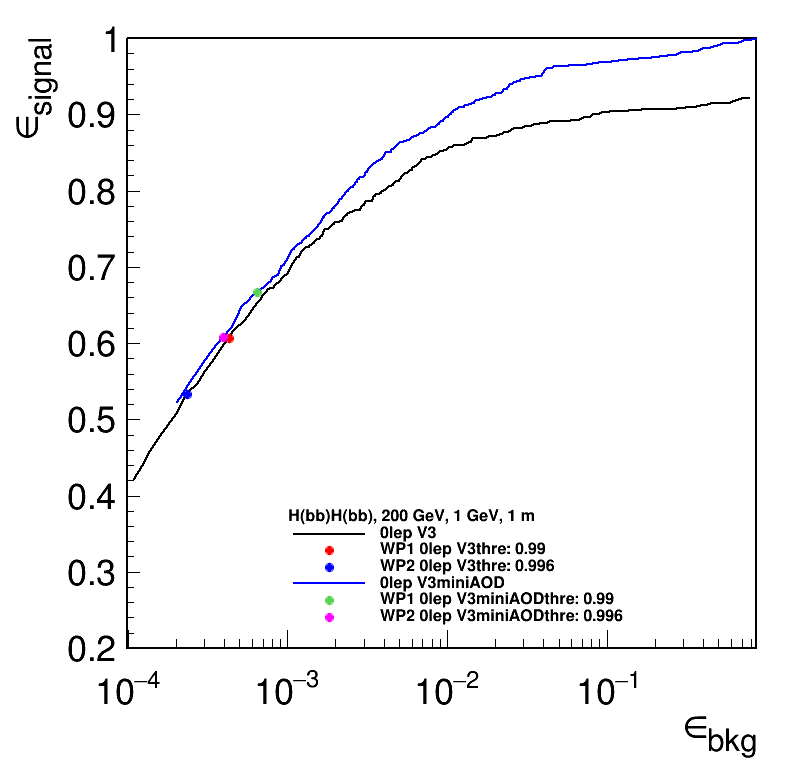

In [14]:
### ROC curve All MC Bkg
 

# sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m',]
minimum_set=0.2
maximum_set=1.0
sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m',]
# sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m','H(bb)H(bb), 400 GeV, 1 GeV, 1 m']
var_keys = ['jetDNNScoreV3', 'jetDNNScoreV3miniAOD']
# sig_cutbase_0lep_effs = {}
# sig_cutbase_0lep_effs['H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = sig200_cutbase_0lep_eff
# sig_cutbase_0lep_effs['H(bb)H(bb), 400 GeV, 1 GeV, 1 m'] = sig400_cutbase_0lep_eff
# sig_cutbase_1lep_effs = {}
# sig_cutbase_1lep_effs['H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = sig200_cutbase_1lep_eff
# sig_cutbase_1lep_effs['H(bb)H(bb), 400 GeV, 1 GeV, 1 m'] = sig400_cutbase_1lep_eff

for sig_k in sig_keys:
    i=0
    print(sig_k, var_k)
    print(len(DataEffv3_0lep[var_k]))
    print(len(Noeffv3_0lep[var_k][sig_k]))
    c = rt.TCanvas('c','c', 800, 800)
#     leg = rt.TLegend(0.45,0.19,0.90,0.54)
    leg = rt.TLegend(0.35,0.19,0.86,0.34)
#     leg = rt.TLegend(0.65,0.19,0.86,0.34)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    gr = {}
#     purity = {}
    for var_k in var_keys:


        #     Plotting ROC curve v3
        gr['Datav3_0lep'+sig_k+var_k] = create_TGraph(DataEffv3_0lep[var_k],Noeffv3_0lep[var_k][sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['Datav3_0lep'+sig_k+var_k].SetLineColor(std_color_list_ext[i])
        gr['Datav3_0lep'+sig_k+var_k].SetLineWidth(2)
        gr['Datav3_0lep'+sig_k+var_k].SetMinimum(minimum_set)
        gr['Datav3_0lep'+sig_k+var_k].SetMaximum(maximum_set)
        gr['Datav3_0lep'+sig_k+var_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['Datav3_0lep'+sig_k+var_k].GetXaxis().SetLimits(0.0, 1.0)

        gr['Datav3_0lep'+sig_k+var_k].Draw('ac' if i==0 else 'c')
#         leg.AddEntry(gr['Datav3_0lep'+sig_k+var_k],'DNN V3 0lep, '+sig_k, 'l')
        leg.AddEntry(gr['Datav3_0lep'+sig_k+var_k],'0lep '+var_k.replace('jetDNNScore',''), 'l')



        #  working point 1 
        i+=1
        wp1_eff_0lep_sig_pt = np.array([Noeffv3_0lep[var_k][sig_k][wp_1_cnt]]) 
        wp1_eff_0lep_bkg_pt = np.array([DataEffv3_0lep[var_k][wp_1_cnt]]) 
        print(wp1_eff_0lep_sig_pt,wp1_eff_0lep_bkg_pt)
        gr['WP1_0lep'+sig_k+var_k] = create_TGraph(wp1_eff_0lep_bkg_pt,wp1_eff_0lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['WP1_0lep'+sig_k+var_k].SetMarkerSize(1.)
        gr['WP1_0lep'+sig_k+var_k].SetMarkerColor(std_color_list_ext[i])
        gr['WP1_0lep'+sig_k+var_k].SetLineColor(std_color_list_ext[i])
        gr['WP1_0lep'+sig_k+var_k].SetMinimum(minimum_set)
        gr['WP1_0lep'+sig_k+var_k].SetMaximum(maximum_set)
        gr['WP1_0lep'+sig_k+var_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['WP1_0lep'+sig_k+var_k].GetXaxis().SetLimits(0.0, 1.0)


        gr['WP1_0lep'+sig_k+var_k].Draw('psame')
        leg.AddEntry(gr['WP1_0lep'+sig_k+var_k],'WP1 0lep '+var_k.replace('jetDNNScore','')+'thre: '+str(wp_1),'p')
        

        #  working point 2 
        i+=1
        wp2_eff_0lep_sig_pt = np.array([Noeffv3_0lep[var_k][sig_k][wp_2_cnt]]) 
        wp2_eff_0lep_bkg_pt = np.array([DataEffv3_0lep[var_k][wp_2_cnt]]) 
        print(wp2_eff_0lep_sig_pt,wp2_eff_0lep_bkg_pt)
        gr['WP2_0lep'+sig_k+var_k] = create_TGraph(wp2_eff_0lep_bkg_pt,wp2_eff_0lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['WP2_0lep'+sig_k+var_k].SetMarkerSize(1.)
        gr['WP2_0lep'+sig_k+var_k].SetMarkerColor(std_color_list_ext[i])
        gr['WP2_0lep'+sig_k+var_k].SetLineColor(std_color_list_ext[i])
        gr['WP2_0lep'+sig_k+var_k].SetMinimum(minimum_set)
        gr['WP2_0lep'+sig_k+var_k].SetMaximum(maximum_set)
        gr['WP2_0lep'+sig_k+var_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['WP2_0lep'+sig_k+var_k].GetXaxis().SetLimits(0.0, 1.0)


        gr['WP2_0lep'+sig_k+var_k].Draw('psame')
        leg.AddEntry(gr['WP2_0lep'+sig_k+var_k],'WP2 0lep '+var_k.replace('jetDNNScore','')+'thre: '+str(wp_2),'p')




    leg.SetHeader(sig_k)
    leg.Draw()
    c.SetLogx()

    c.Draw()
    c.SaveAs(plotDir+'V3_ROC_DNN_Data_BKG_Sig'+sig_k.replace('H(bb)H(bb), ','').replace(' GeV, 1 GeV, 1 m','GeV')+'_0lep.png')


H(bb)H(bb), 200 GeV, 1 GeV, 1 m jetDNNScoreV3
999
999
[0.60606053] [0.00033672]
[0.53351693] [0.00018817]
H(bb)H(bb), 200 GeV, 1 GeV, 1 m jetDNNScoreV3miniAOD
999
999
[0.66666656] [0.00052184]
[0.60789711] [0.00031768]
H(bb)H(bb), 400 GeV, 1 GeV, 1 m jetDNNScoreV3
999
999
[0.64237239] [0.00033672]
[0.58786252] [0.00018817]
H(bb)H(bb), 400 GeV, 1 GeV, 1 m jetDNNScoreV3miniAOD
999
999
[0.71106578] [0.00052184]
[0.66985585] [0.00031768]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/2018_sigmatch/dnn_v3_miniAOD_0lep_1lep_roc/V3_ROC_DNN_Data_BKG_Sig200GeV_1lep.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/2018_sigmatch/dnn_v3_miniAOD_0lep_1lep_roc/V3_ROC_DNN_Data_BKG_Sig400GeV_1lep.png has been created


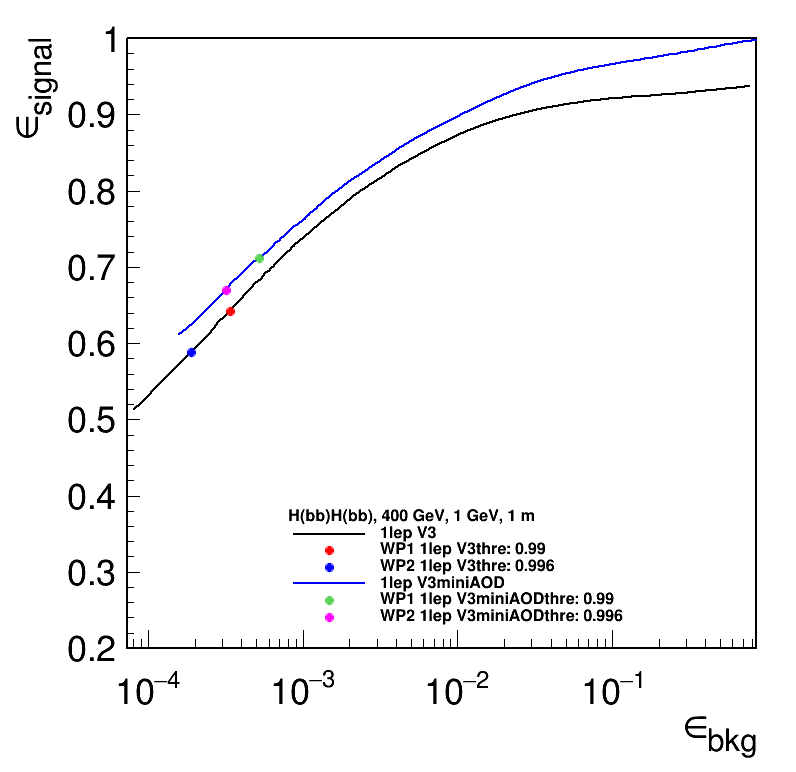

In [17]:
### ROC curve All MC Bkg
 

# sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m',]
minimum_set=0.2
maximum_set=1.0
sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m','H(bb)H(bb), 400 GeV, 1 GeV, 1 m']
var_keys = ['jetDNNScoreV3', 'jetDNNScoreV3miniAOD']
# sig_cutbase_0lep_effs = {}
# sig_cutbase_0lep_effs['H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = sig200_cutbase_0lep_eff
# sig_cutbase_0lep_effs['H(bb)H(bb), 400 GeV, 1 GeV, 1 m'] = sig400_cutbase_0lep_eff
# sig_cutbase_1lep_effs = {}
# sig_cutbase_1lep_effs['H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = sig200_cutbase_1lep_eff
# sig_cutbase_1lep_effs['H(bb)H(bb), 400 GeV, 1 GeV, 1 m'] = sig400_cutbase_1lep_eff

for sig_k in sig_keys:
    i=0

    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.35,0.19,0.86,0.34)
#     leg = rt.TLegend(0.45,0.19,0.90,0.54)
#     leg = rt.TLegend(0.65,0.19,0.86,0.34)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    gr = {}
#     purity = {}
    for var_k in var_keys:
        
        print(sig_k, var_k)
        print(len(DataEffv3_0lep[var_k]))
        print(len(Noeffv3_0lep[var_k][sig_k]))


        #ROC 1lep
#         i+=1
        gr['Datav3_1lep'+sig_k+var_k] = create_TGraph(DataEffv3_1lep[var_k],Noeffv3_1lep[var_k][sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['Datav3_1lep'+sig_k+var_k].SetLineColor(std_color_list_ext[i])
        gr['Datav3_1lep'+sig_k+var_k].SetLineWidth(2)
        gr['Datav3_1lep'+sig_k+var_k].SetMinimum(minimum_set)
        gr['Datav3_1lep'+sig_k+var_k].SetMaximum(maximum_set)
        gr['Datav3_1lep'+sig_k+var_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['Datav3_1lep'+sig_k+var_k].GetXaxis().SetLimits(0.0, 1.0)

        gr['Datav3_1lep'+sig_k+var_k].Draw('acsame' if i==0 else 'csame')
#         leg.AddEntry(gr['Datav3_1lep'+sig_k+var_k],'DNN V3 1lep, '+sig_k, 'l')
        leg.AddEntry(gr['Datav3_1lep'+sig_k+var_k],'1lep '+var_k.replace('jetDNNScore',''), 'l')


        #  working point 1 
        i+=1
        wp1_eff_1lep_sig_pt = np.array([Noeffv3_1lep[var_k][sig_k][wp_1_cnt]]) 
        wp1_eff_1lep_bkg_pt = np.array([DataEffv3_1lep[var_k][wp_1_cnt]]) 
        print(wp1_eff_1lep_sig_pt,wp1_eff_1lep_bkg_pt)
        gr['WP1_1lep'+sig_k+var_k] = create_TGraph(wp1_eff_1lep_bkg_pt,wp1_eff_1lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['WP1_1lep'+sig_k+var_k].SetMarkerSize(1.)
        gr['WP1_1lep'+sig_k+var_k].SetMarkerColor(std_color_list_ext[i])
        gr['WP1_1lep'+sig_k+var_k].SetLineColor(std_color_list_ext[i])
        gr['WP1_1lep'+sig_k+var_k].SetMinimum(minimum_set)
        gr['WP1_1lep'+sig_k+var_k].SetMaximum(maximum_set)
        gr['WP1_1lep'+sig_k+var_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['WP1_1lep'+sig_k+var_k].GetXaxis().SetLimits(0.0, 1.0)


        gr['WP1_1lep'+sig_k+var_k].Draw('psame')
        leg.AddEntry(gr['WP1_1lep'+sig_k+var_k],'WP1 1lep '+var_k.replace('jetDNNScore','')+'thre: '+str(wp_1),'p')
        

        #  working point 2 
        i+=1
        wp2_eff_1lep_sig_pt = np.array([Noeffv3_1lep[var_k][sig_k][wp_2_cnt]]) 
        wp2_eff_1lep_bkg_pt = np.array([DataEffv3_1lep[var_k][wp_2_cnt]]) 
        print(wp2_eff_1lep_sig_pt,wp2_eff_1lep_bkg_pt)
        gr['WP2_1lep'+sig_k+var_k] = create_TGraph(wp2_eff_1lep_bkg_pt,wp2_eff_1lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['WP2_1lep'+sig_k+var_k].SetMarkerSize(1.)
        gr['WP2_1lep'+sig_k+var_k].SetMarkerColor(std_color_list_ext[i])
        gr['WP2_1lep'+sig_k+var_k].SetLineColor(std_color_list_ext[i])
        gr['WP2_1lep'+sig_k+var_k].SetMinimum(minimum_set)
        gr['WP2_1lep'+sig_k+var_k].SetMaximum(maximum_set)
        gr['WP2_1lep'+sig_k+var_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['WP2_1lep'+sig_k+var_k].GetXaxis().SetLimits(0.0, 1.0)


        gr['WP2_1lep'+sig_k+var_k].Draw('psame')
        leg.AddEntry(gr['WP2_1lep'+sig_k+var_k],'WP2 1lep '+var_k.replace('jetDNNScore','')+'thre: '+str(wp_2),'p')


    leg.SetHeader(sig_k)
    leg.Draw()
    c.SetLogx()

    c.Draw()
    c.SaveAs(plotDir+'V3_ROC_DNN_Data_BKG_Sig'+sig_k.replace('H(bb)H(bb), ','').replace(' GeV, 1 GeV, 1 m','GeV')+'_1lep.png')


H(bb)H(bb), 200 GeV, 1 GeV, 1 m jetDNNScoreV3miniAOD
999
999
[0.60606053] [0.00042929]
[0.53351693] [0.00023526]
[0.60606053] [0.00033672]
[0.53351693] [0.00018817]
[0.66666656] [0.00064213]
[0.60789711] [0.00039475]
[0.66666656] [0.00052184]
[0.60789711] [0.00031768]
H(bb)H(bb), 400 GeV, 1 GeV, 1 m jetDNNScoreV3miniAOD
999
999
[0.64237239] [0.00042929]
[0.58786252] [0.00023526]
[0.64237239] [0.00033672]
[0.58786252] [0.00018817]
[0.71106578] [0.00064213]
[0.66985585] [0.00039475]
[0.71106578] [0.00052184]
[0.66985585] [0.00031768]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/2018_sigmatch/dnn_v3_miniAOD_0lep_1lep_roc/V3_ROC_DNN_Data_BKG_Sig200GeV.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/2018_sigmatch/dnn_v3_miniAOD_0lep_1lep_roc/V3_ROC_DNN_Data_BKG_Sig400GeV.png has been created


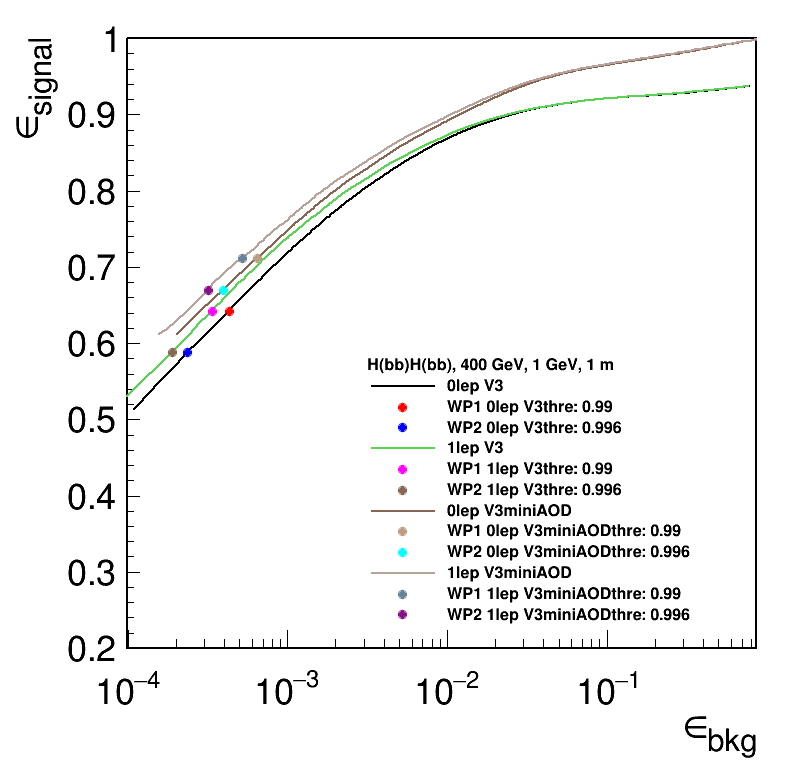

In [46]:
### ROC curve All MC Bkg
 

# sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m',]
minimum_set=0.2
maximum_set=1.0
sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m','H(bb)H(bb), 400 GeV, 1 GeV, 1 m']
var_keys = ['jetDNNScoreV3', 'jetDNNScoreV3miniAOD']
# sig_cutbase_0lep_effs = {}
# sig_cutbase_0lep_effs['H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = sig200_cutbase_0lep_eff
# sig_cutbase_0lep_effs['H(bb)H(bb), 400 GeV, 1 GeV, 1 m'] = sig400_cutbase_0lep_eff
# sig_cutbase_1lep_effs = {}
# sig_cutbase_1lep_effs['H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = sig200_cutbase_1lep_eff
# sig_cutbase_1lep_effs['H(bb)H(bb), 400 GeV, 1 GeV, 1 m'] = sig400_cutbase_1lep_eff

for sig_k in sig_keys:
    i=0
    print(sig_k, var_k)
    print(len(DataEffv3_0lep[var_k]))
    print(len(Noeffv3_0lep[var_k][sig_k]))
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.45,0.19,0.90,0.54)
#     leg = rt.TLegend(0.65,0.19,0.86,0.34)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    gr = {}
#     purity = {}
    for var_k in var_keys:


        #     Plotting ROC curve v3
        gr['Datav3_0lep'+sig_k+var_k] = create_TGraph(DataEffv3_0lep[var_k],Noeffv3_0lep[var_k][sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['Datav3_0lep'+sig_k+var_k].SetLineColor(std_color_list_ext[i])
        gr['Datav3_0lep'+sig_k+var_k].SetLineWidth(2)
        gr['Datav3_0lep'+sig_k+var_k].SetMinimum(minimum_set)
        gr['Datav3_0lep'+sig_k+var_k].SetMaximum(maximum_set)
        gr['Datav3_0lep'+sig_k+var_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['Datav3_0lep'+sig_k+var_k].GetXaxis().SetLimits(0.0, 1.0)

        gr['Datav3_0lep'+sig_k+var_k].Draw('ac' if i==0 else 'c')
#         leg.AddEntry(gr['Datav3_0lep'+sig_k+var_k],'DNN V3 0lep, '+sig_k, 'l')
        leg.AddEntry(gr['Datav3_0lep'+sig_k+var_k],'0lep '+var_k.replace('jetDNNScore',''), 'l')



        #  working point 1 
        i+=1
        wp1_eff_0lep_sig_pt = np.array([Noeffv3_0lep[var_k][sig_k][wp_1_cnt]]) 
        wp1_eff_0lep_bkg_pt = np.array([DataEffv3_0lep[var_k][wp_1_cnt]]) 
        print(wp1_eff_0lep_sig_pt,wp1_eff_0lep_bkg_pt)
        gr['WP1_0lep'+sig_k+var_k] = create_TGraph(wp1_eff_0lep_bkg_pt,wp1_eff_0lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['WP1_0lep'+sig_k+var_k].SetMarkerSize(1.)
        gr['WP1_0lep'+sig_k+var_k].SetMarkerColor(std_color_list_ext[i])
        gr['WP1_0lep'+sig_k+var_k].SetLineColor(std_color_list_ext[i])
        gr['WP1_0lep'+sig_k+var_k].SetMinimum(minimum_set)
        gr['WP1_0lep'+sig_k+var_k].SetMaximum(maximum_set)
        gr['WP1_0lep'+sig_k+var_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['WP1_0lep'+sig_k+var_k].GetXaxis().SetLimits(0.0, 1.0)


        gr['WP1_0lep'+sig_k+var_k].Draw('psame')
        leg.AddEntry(gr['WP1_0lep'+sig_k+var_k],'WP1 0lep '+var_k.replace('jetDNNScore','')+'thre: '+str(wp_1),'p')
        

        #  working point 2 
        i+=1
        wp2_eff_0lep_sig_pt = np.array([Noeffv3_0lep[var_k][sig_k][wp_2_cnt]]) 
        wp2_eff_0lep_bkg_pt = np.array([DataEffv3_0lep[var_k][wp_2_cnt]]) 
        print(wp2_eff_0lep_sig_pt,wp2_eff_0lep_bkg_pt)
        gr['WP2_0lep'+sig_k+var_k] = create_TGraph(wp2_eff_0lep_bkg_pt,wp2_eff_0lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['WP2_0lep'+sig_k+var_k].SetMarkerSize(1.)
        gr['WP2_0lep'+sig_k+var_k].SetMarkerColor(std_color_list_ext[i])
        gr['WP2_0lep'+sig_k+var_k].SetLineColor(std_color_list_ext[i])
        gr['WP2_0lep'+sig_k+var_k].SetMinimum(minimum_set)
        gr['WP2_0lep'+sig_k+var_k].SetMaximum(maximum_set)
        gr['WP2_0lep'+sig_k+var_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['WP2_0lep'+sig_k+var_k].GetXaxis().SetLimits(0.0, 1.0)


        gr['WP2_0lep'+sig_k+var_k].Draw('psame')
        leg.AddEntry(gr['WP2_0lep'+sig_k+var_k],'WP2 0lep '+var_k.replace('jetDNNScore','')+'thre: '+str(wp_2),'p')


        #ROC 1lep
        i+=1
        gr['Datav3_1lep'+sig_k+var_k] = create_TGraph(DataEffv3_1lep[var_k],Noeffv3_1lep[var_k][sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['Datav3_1lep'+sig_k+var_k].SetLineColor(std_color_list_ext[i])
        gr['Datav3_1lep'+sig_k+var_k].SetLineWidth(2)
        gr['Datav3_1lep'+sig_k+var_k].SetMinimum(minimum_set)
        gr['Datav3_1lep'+sig_k+var_k].SetMaximum(maximum_set)
        gr['Datav3_1lep'+sig_k+var_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['Datav3_1lep'+sig_k+var_k].GetXaxis().SetLimits(0.0, 1.0)

        gr['Datav3_1lep'+sig_k+var_k].Draw('csame')
#         leg.AddEntry(gr['Datav3_1lep'+sig_k+var_k],'DNN V3 1lep, '+sig_k, 'l')
        leg.AddEntry(gr['Datav3_1lep'+sig_k+var_k],'1lep '+var_k.replace('jetDNNScore',''), 'l')


        #  working point 1 
        i+=1
        wp1_eff_1lep_sig_pt = np.array([Noeffv3_1lep[var_k][sig_k][wp_1_cnt]]) 
        wp1_eff_1lep_bkg_pt = np.array([DataEffv3_1lep[var_k][wp_1_cnt]]) 
        print(wp1_eff_1lep_sig_pt,wp1_eff_1lep_bkg_pt)
        gr['WP1_1lep'+sig_k+var_k] = create_TGraph(wp1_eff_1lep_bkg_pt,wp1_eff_1lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['WP1_1lep'+sig_k+var_k].SetMarkerSize(1.)
        gr['WP1_1lep'+sig_k+var_k].SetMarkerColor(std_color_list_ext[i])
        gr['WP1_1lep'+sig_k+var_k].SetLineColor(std_color_list_ext[i])
        gr['WP1_1lep'+sig_k+var_k].SetMinimum(minimum_set)
        gr['WP1_1lep'+sig_k+var_k].SetMaximum(maximum_set)
        gr['WP1_1lep'+sig_k+var_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['WP1_1lep'+sig_k+var_k].GetXaxis().SetLimits(0.0, 1.0)


        gr['WP1_1lep'+sig_k+var_k].Draw('psame')
        leg.AddEntry(gr['WP1_1lep'+sig_k+var_k],'WP1 1lep '+var_k.replace('jetDNNScore','')+'thre: '+str(wp_1),'p')
        

        #  working point 2 
        i+=1
        wp2_eff_1lep_sig_pt = np.array([Noeffv3_1lep[var_k][sig_k][wp_2_cnt]]) 
        wp2_eff_1lep_bkg_pt = np.array([DataEffv3_1lep[var_k][wp_2_cnt]]) 
        print(wp2_eff_1lep_sig_pt,wp2_eff_1lep_bkg_pt)
        gr['WP2_1lep'+sig_k+var_k] = create_TGraph(wp2_eff_1lep_bkg_pt,wp2_eff_1lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['WP2_1lep'+sig_k+var_k].SetMarkerSize(1.)
        gr['WP2_1lep'+sig_k+var_k].SetMarkerColor(std_color_list_ext[i])
        gr['WP2_1lep'+sig_k+var_k].SetLineColor(std_color_list_ext[i])
        gr['WP2_1lep'+sig_k+var_k].SetMinimum(minimum_set)
        gr['WP2_1lep'+sig_k+var_k].SetMaximum(maximum_set)
        gr['WP2_1lep'+sig_k+var_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['WP2_1lep'+sig_k+var_k].GetXaxis().SetLimits(0.0, 1.0)


        gr['WP2_1lep'+sig_k+var_k].Draw('psame')
        leg.AddEntry(gr['WP2_1lep'+sig_k+var_k],'WP2 1lep '+var_k.replace('jetDNNScore','')+'thre: '+str(wp_2),'p')


    leg.SetHeader(sig_k)
    leg.Draw()
    c.SetLogx()

    c.Draw()
    c.SaveAs(plotDir+'V3_ROC_DNN_Data_BKG_Sig'+sig_k.replace('H(bb)H(bb), ','').replace(' GeV, 1 GeV, 1 m','GeV')+'.png')


[0.49863] [0.000422]
[0.61943312] [0.00042929]
4
[0.315789] [0.000343]
[0.61943312] [0.00033672]
[0.481758] [0.000422]
[0.64237239] [0.00042929]
10
[0.464314] [0.000343]
[0.64237239] [0.00033672]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/2018_sigmatch/dnn_v3_0lep_1lep_roc/V3_ROC_DNN_Data_BKG_SIG.png has been created


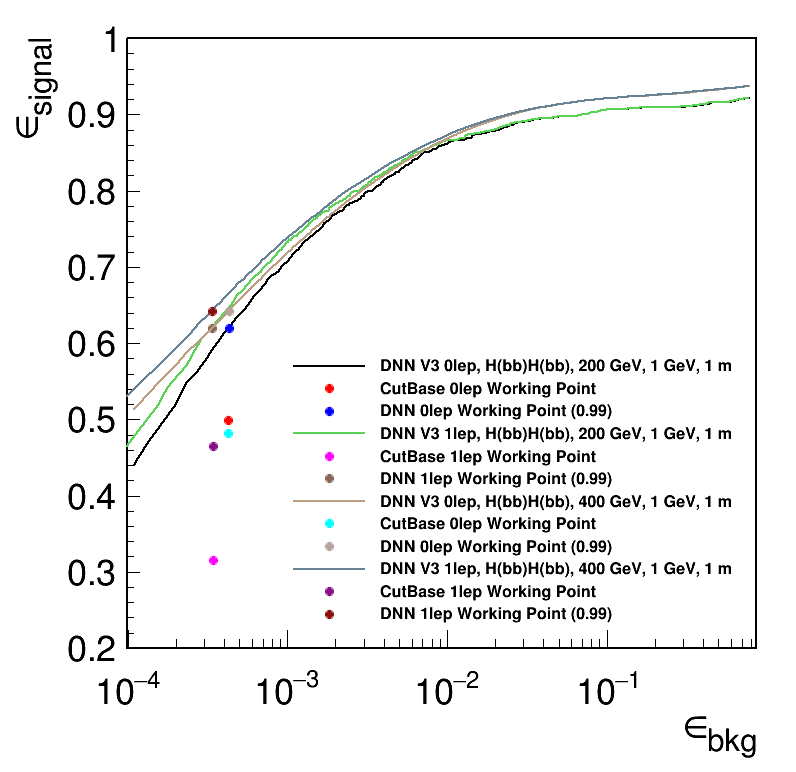

In [37]:
### ROC curve All MC Bkg
std_color_list_ext = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36, 221, 205, 209, 216, 213, 52, 148]

i=0
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.35,0.19,0.86,0.54)
#     leg = rt.TLegend(0.65,0.19,0.86,0.34)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr = {}
purity = {}
for sig_k in sig_keys:


    #     Plotting ROC curve v3
    gr['Datav3_0lep'+sig_k] = create_TGraph(DataEffv3_0lep,Noeffv3_0lep[sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    gr['Datav3_0lep'+sig_k].SetLineColor(std_color_list_ext[i])
    gr['Datav3_0lep'+sig_k].SetLineWidth(2)
    gr['Datav3_0lep'+sig_k].SetMinimum(minimum_set)
    gr['Datav3_0lep'+sig_k].SetMaximum(maximum_set)
    gr['Datav3_0lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
    gr['Datav3_0lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)

    gr['Datav3_0lep'+sig_k].Draw('ac' if i==0 else 'c')
    leg.AddEntry(gr['Datav3_0lep'+sig_k],'DNN V3 0lep, '+sig_k, 'l')
    


    #cutbased working point
    i+=1
    cutbase_eff_0lep_sig_pt = np.array([sig_cutbase_0lep_effs[sig_k]]) 
    cutbase_eff_0lep_bkg_pt = np.array([data_cutbase_0lep_eff]) 
    print(cutbase_eff_0lep_sig_pt,cutbase_eff_0lep_bkg_pt)
    gr['CutBase_0lep'+sig_k] = create_TGraph(cutbase_eff_0lep_bkg_pt,cutbase_eff_0lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    gr['CutBase_0lep'+sig_k].SetMarkerSize(1.)
    gr['CutBase_0lep'+sig_k].SetMarkerColor(std_color_list_ext[i])
    gr['CutBase_0lep'+sig_k].SetLineColor(std_color_list_ext[i])
    gr['CutBase_0lep'+sig_k].SetMinimum(minimum_set)
    gr['CutBase_0lep'+sig_k].SetMaximum(maximum_set)
    gr['CutBase_0lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
    gr['CutBase_0lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)


    gr['CutBase_0lep'+sig_k].Draw('psame')
    leg.AddEntry(gr['CutBase_0lep'+sig_k],'CutBase 0lep Working Point','p')
    
    #aiming dnn working point
    i+=1
    dnn_eff_0lep_sig_pt = np.array([Noeffv3_0lep[sig_k][aim_nothre_0lep_cntv3]]) 
    dnn_eff_0lep_bkg_pt = np.array([DataEffv3_0lep[aim_nothre_0lep_cntv3]]) 
    print(dnn_eff_0lep_sig_pt,dnn_eff_0lep_bkg_pt)
    gr['AimDNNv3_0lep'+sig_k] = create_TGraph(dnn_eff_0lep_bkg_pt,dnn_eff_0lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    gr['AimDNNv3_0lep'+sig_k].SetMarkerSize(1.)
    gr['AimDNNv3_0lep'+sig_k].SetMarkerColor(std_color_list_ext[i])
    gr['AimDNNv3_0lep'+sig_k].SetLineColor(std_color_list_ext[i])
    gr['AimDNNv3_0lep'+sig_k].SetMinimum(minimum_set)
    gr['AimDNNv3_0lep'+sig_k].SetMaximum(maximum_set)
    gr['AimDNNv3_0lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
    gr['AimDNNv3_0lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)


    gr['AimDNNv3_0lep'+sig_k].Draw('psame')
    leg.AddEntry(gr['AimDNNv3_0lep'+sig_k],'DNN 0lep Working Point ('+str(aim_nothre_ptv3)+')','p')
 
    #ROC 1lep
    i+=1
    gr['Datav3_1lep'+sig_k] = create_TGraph(DataEffv3_1lep,Noeffv3_1lep[sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    gr['Datav3_1lep'+sig_k].SetLineColor(std_color_list_ext[i])
    gr['Datav3_1lep'+sig_k].SetLineWidth(2)
    gr['Datav3_1lep'+sig_k].SetMinimum(minimum_set)
    gr['Datav3_1lep'+sig_k].SetMaximum(maximum_set)
    gr['Datav3_1lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
    gr['Datav3_1lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)

    gr['Datav3_1lep'+sig_k].Draw('csame')
    leg.AddEntry(gr['Datav3_1lep'+sig_k],'DNN V3 1lep, '+sig_k, 'l')

    #cutbased working point
    i+=1
    print(i)
    cutbase_eff_1lep_sig_pt = np.array([sig_cutbase_1lep_effs[sig_k]]) 
    cutbase_eff_1lep_bkg_pt = np.array([data_cutbase_1lep_eff]) 
    print(cutbase_eff_1lep_sig_pt,cutbase_eff_1lep_bkg_pt)
    gr['CutBase_1lep'+sig_k] = create_TGraph(cutbase_eff_1lep_bkg_pt,cutbase_eff_1lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    gr['CutBase_1lep'+sig_k].SetMarkerSize(1.)
    gr['CutBase_1lep'+sig_k].SetMarkerColor(std_color_list_ext[i])
    gr['CutBase_1lep'+sig_k].SetLineColor(std_color_list_ext[i])
    gr['CutBase_1lep'+sig_k].SetMinimum(minimum_set)
    gr['CutBase_1lep'+sig_k].SetMaximum(maximum_set)
    gr['CutBase_1lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
    gr['CutBase_1lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)


    gr['CutBase_1lep'+sig_k].Draw('psame')
    leg.AddEntry(gr['CutBase_1lep'+sig_k],'CutBase 1lep Working Point','p')
    
    #aiming dnn working point
    i+=1
    dnn_eff_1lep_sig_pt = np.array([Noeffv3_1lep[sig_k][aim_nothre_1lep_cntv3]]) 
    dnn_eff_1lep_bkg_pt = np.array([DataEffv3_1lep[aim_nothre_1lep_cntv3]]) 
    print(dnn_eff_1lep_sig_pt,dnn_eff_1lep_bkg_pt)
    gr['AimDNNv3_1lep'+sig_k] = create_TGraph(dnn_eff_1lep_bkg_pt,dnn_eff_1lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    gr['AimDNNv3_1lep'+sig_k].SetMarkerSize(1.)
    gr['AimDNNv3_1lep'+sig_k].SetMarkerColor(std_color_list_ext[i])
    gr['AimDNNv3_1lep'+sig_k].SetLineColor(std_color_list_ext[i])
    gr['AimDNNv3_1lep'+sig_k].SetMinimum(minimum_set)
    gr['AimDNNv3_1lep'+sig_k].SetMaximum(maximum_set)
    gr['AimDNNv3_1lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
    gr['AimDNNv3_1lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)


    gr['AimDNNv3_1lep'+sig_k].Draw('psame')
    leg.AddEntry(gr['AimDNNv3_1lep'+sig_k],'DNN 1lep Working Point ('+str(aim_nothre_ptv3)+')','p')    

    i+=1
    
  
leg.Draw()
c.SetLogx()

c.Draw()
c.SaveAs(plotDir+'V3_ROC_DNN_Data_BKG_SIG.png')


## Backup

H(bb)H(bb), 200 GeV, 1 GeV, 1 m jetDNNScoreV3
999
999
H(bb)H(bb), 200 GeV, 1 GeV, 1 m jetDNNScoreV3miniAOD
999
999
H(bb)H(bb), 400 GeV, 1 GeV, 1 m jetDNNScoreV3
999
999
H(bb)H(bb), 400 GeV, 1 GeV, 1 m jetDNNScoreV3miniAOD
999
999


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


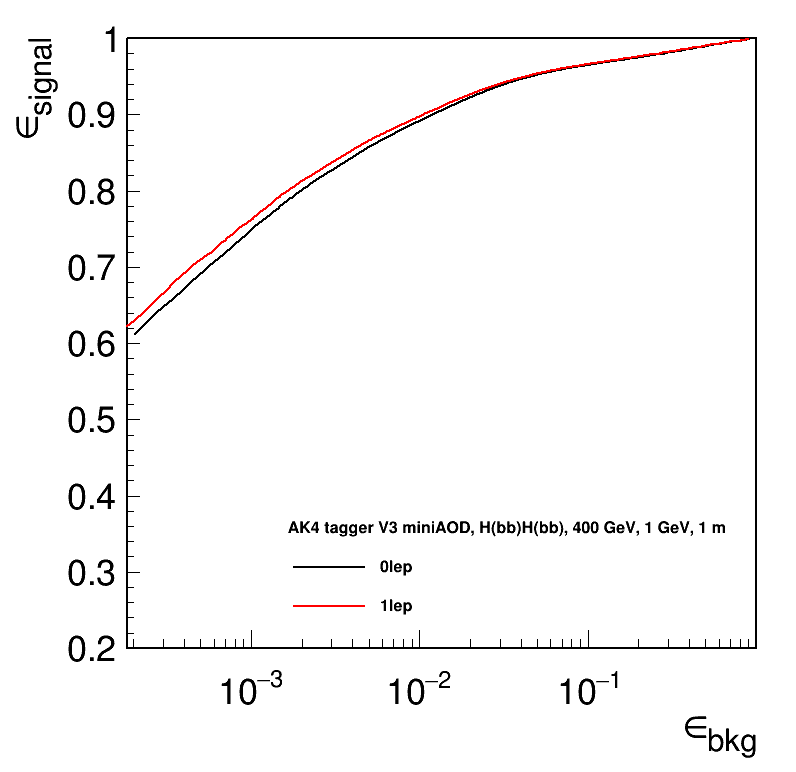

In [19]:
### ROC curve All MC Bkg
 

# sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m',]
minimum_set=0.2
maximum_set=1.0
sig_keys = ['H(bb)H(bb), 200 GeV, 1 GeV, 1 m','H(bb)H(bb), 400 GeV, 1 GeV, 1 m']
var_keys = ['jetDNNScoreV3', 'jetDNNScoreV3miniAOD']
# sig_cutbase_0lep_effs = {}
# sig_cutbase_0lep_effs['H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = sig200_cutbase_0lep_eff
# sig_cutbase_0lep_effs['H(bb)H(bb), 400 GeV, 1 GeV, 1 m'] = sig400_cutbase_0lep_eff
# sig_cutbase_1lep_effs = {}
# sig_cutbase_1lep_effs['H(bb)H(bb), 200 GeV, 1 GeV, 1 m'] = sig200_cutbase_1lep_eff
# sig_cutbase_1lep_effs['H(bb)H(bb), 400 GeV, 1 GeV, 1 m'] = sig400_cutbase_1lep_eff

for sig_k in sig_keys:
    for var_k in var_keys:
        i=0
        print(sig_k, var_k)
        print(len(DataEffv3_0lep[var_k]))
        print(len(Noeffv3_0lep[var_k][sig_k]))
        c = rt.TCanvas('c','c', 800, 800)
        leg = rt.TLegend(0.35,0.19,0.86,0.34)
    #     leg = rt.TLegend(0.65,0.19,0.86,0.34)
        leg.SetTextSize(0.022)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        gr = {}
        purity = {}

        #     Plotting ROC curve v3
        gr['Datav3_0lep'+sig_k] = create_TGraph(DataEffv3_0lep[var_k],Noeffv3_0lep[var_k][sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['Datav3_0lep'+sig_k].SetLineColor(std_color_list[i])
        gr['Datav3_0lep'+sig_k].SetLineWidth(2)
        gr['Datav3_0lep'+sig_k].SetMinimum(minimum_set)
        gr['Datav3_0lep'+sig_k].SetMaximum(maximum_set)
        gr['Datav3_0lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['Datav3_0lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)

        gr['Datav3_0lep'+sig_k].Draw('ac' if i==0 else 'c')
#         leg.AddEntry(gr['Datav3_0lep'+sig_k],'DNN V3 0lep, '+sig_k, 'l')
        leg.AddEntry(gr['Datav3_0lep'+sig_k],'0lep', 'l')



    #     #cutbased working point
    #     i+=1
    #     cutbase_eff_0lep_sig_pt = np.array([sig_cutbase_0lep_effs[sig_k]]) 
    #     cutbase_eff_0lep_bkg_pt = np.array([data_cutbase_0lep_eff]) 
    #     print(cutbase_eff_0lep_sig_pt,cutbase_eff_0lep_bkg_pt)
    #     gr['CutBase_0lep'+sig_k] = create_TGraph(cutbase_eff_0lep_bkg_pt,cutbase_eff_0lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    #     gr['CutBase_0lep'+sig_k].SetMarkerSize(1.)
    #     gr['CutBase_0lep'+sig_k].SetMarkerColor(std_color_list[i])
    #     gr['CutBase_0lep'+sig_k].SetLineColor(std_color_list[i])
    #     gr['CutBase_0lep'+sig_k].SetMinimum(minimum_set)
    #     gr['CutBase_0lep'+sig_k].SetMaximum(maximum_set)
    #     gr['CutBase_0lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
    #     gr['CutBase_0lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)


    #     gr['CutBase_0lep'+sig_k].Draw('psame')
    #     leg.AddEntry(gr['CutBase_0lep'+sig_k],'CutBase 0lep Working Point','p')

    #     #aiming dnn working point
    #     i+=1
    #     dnn_eff_0lep_sig_pt = np.array([Noeffv3_0lep[sig_k][aim_nothre_0lep_cntv3]]) 
    #     dnn_eff_0lep_bkg_pt = np.array([DataEffv3_0lep[aim_nothre_0lep_cntv3]]) 
    #     print(dnn_eff_0lep_sig_pt,dnn_eff_0lep_bkg_pt)
    #     gr['AimDNNv3_0lep'+sig_k] = create_TGraph(dnn_eff_0lep_bkg_pt,dnn_eff_0lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    #     gr['AimDNNv3_0lep'+sig_k].SetMarkerSize(1.)
    #     gr['AimDNNv3_0lep'+sig_k].SetMarkerColor(std_color_list[i])
    #     gr['AimDNNv3_0lep'+sig_k].SetLineColor(std_color_list[i])
    #     gr['AimDNNv3_0lep'+sig_k].SetMinimum(minimum_set)
    #     gr['AimDNNv3_0lep'+sig_k].SetMaximum(maximum_set)
    #     gr['AimDNNv3_0lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
    #     gr['AimDNNv3_0lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)


    #     gr['AimDNNv3_0lep'+sig_k].Draw('psame')
    #     leg.AddEntry(gr['AimDNNv3_0lep'+sig_k],'DNN 0lep Working Point ('+str(aim_nothre_ptv3)+')','p')

        #ROC 1lep
        i+=1
        gr['Datav3_1lep'+sig_k] = create_TGraph(DataEffv3_1lep[var_k],Noeffv3_1lep[var_k][sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        gr['Datav3_1lep'+sig_k].SetLineColor(std_color_list[i])
        gr['Datav3_1lep'+sig_k].SetLineWidth(2)
        gr['Datav3_1lep'+sig_k].SetMinimum(minimum_set)
        gr['Datav3_1lep'+sig_k].SetMaximum(maximum_set)
        gr['Datav3_1lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
        gr['Datav3_1lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)

        gr['Datav3_1lep'+sig_k].Draw('csame')
#         leg.AddEntry(gr['Datav3_1lep'+sig_k],'DNN V3 1lep, '+sig_k, 'l')
        leg.AddEntry(gr['Datav3_1lep'+sig_k],'1lep ', 'l')

    #     #cutbased working point
    #     i+=1
    #     cutbase_eff_1lep_sig_pt = np.array([sig_cutbase_1lep_effs[sig_k]]) 
    #     cutbase_eff_1lep_bkg_pt = np.array([data_cutbase_1lep_eff]) 
    #     print(cutbase_eff_1lep_sig_pt,cutbase_eff_1lep_bkg_pt)
    #     gr['CutBase_1lep'+sig_k] = create_TGraph(cutbase_eff_1lep_bkg_pt,cutbase_eff_1lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    #     gr['CutBase_1lep'+sig_k].SetMarkerSize(1.)
    #     gr['CutBase_1lep'+sig_k].SetMarkerColor(std_color_list[i])
    #     gr['CutBase_1lep'+sig_k].SetLineColor(std_color_list[i])
    #     gr['CutBase_1lep'+sig_k].SetMinimum(minimum_set)
    #     gr['CutBase_1lep'+sig_k].SetMaximum(maximum_set)
    #     gr['CutBase_1lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
    #     gr['CutBase_1lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)


    #     gr['CutBase_1lep'+sig_k].Draw('psame')
    #     leg.AddEntry(gr['CutBase_1lep'+sig_k],'CutBase 1lep Working Point','p')

    #     #aiming dnn working point
    #     i+=1
    #     dnn_eff_1lep_sig_pt = np.array([Noeffv3_1lep[sig_k][aim_nothre_1lep_cntv3]]) 
    #     dnn_eff_1lep_bkg_pt = np.array([DataEffv3_1lep[aim_nothre_1lep_cntv3]]) 
    #     print(dnn_eff_1lep_sig_pt,dnn_eff_1lep_bkg_pt)
    #     gr['AimDNNv3_1lep'+sig_k] = create_TGraph(dnn_eff_1lep_bkg_pt,dnn_eff_1lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    #     gr['AimDNNv3_1lep'+sig_k].SetMarkerSize(1.)
    #     gr['AimDNNv3_1lep'+sig_k].SetMarkerColor(std_color_list[i])
    #     gr['AimDNNv3_1lep'+sig_k].SetLineColor(std_color_list[i])
    #     gr['AimDNNv3_1lep'+sig_k].SetMinimum(minimum_set)
    #     gr['AimDNNv3_1lep'+sig_k].SetMaximum(maximum_set)
    #     gr['AimDNNv3_1lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
    #     gr['AimDNNv3_1lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)


    #     gr['AimDNNv3_1lep'+sig_k].Draw('psame')
    #     leg.AddEntry(gr['AimDNNv3_1lep'+sig_k],'DNN 1lep Working Point ('+str(aim_nothre_ptv3)+')','p')


        leg.SetHeader(var_k.replace('jetDNNScore','AK4 tagger ').replace('V3', 'V3 ')+', '+sig_k)
        leg.Draw()
        c.SetLogx()

        c.Draw()
#         c.SaveAs(plotDir+'V3_ROC_DNN_Data_BKG_Sig'+sig_k+'GeV.png')


[0.49863] [0.000422]
[0.61943312] [0.00042929]
4
[0.315789] [0.000343]
[0.61943312] [0.00033672]
[0.481758] [0.000422]
[0.64237239] [0.00042929]
10
[0.464314] [0.000343]
[0.64237239] [0.00033672]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20210131/2018_sigmatch/dnn_v3_0lep_1lep_roc/V3_ROC_DNN_Data_BKG_SIG.png has been created


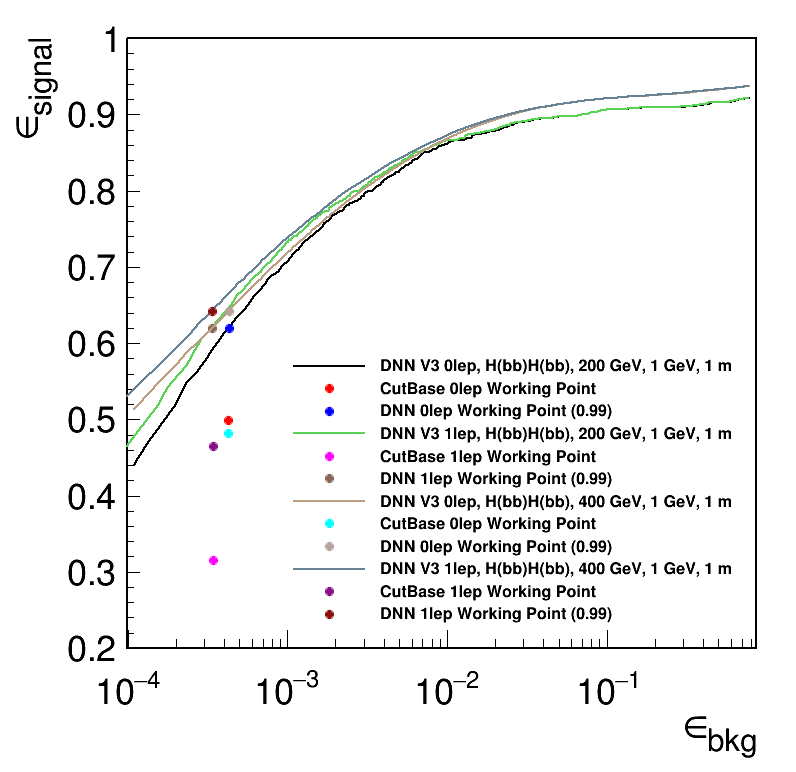

In [37]:
### ROC curve All MC Bkg
std_color_list_ext = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36, 221, 205, 209, 216, 213, 52, 148]

i=0
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.35,0.19,0.86,0.54)
#     leg = rt.TLegend(0.65,0.19,0.86,0.34)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr = {}
purity = {}
for sig_k in sig_keys:


    #     Plotting ROC curve v3
    gr['Datav3_0lep'+sig_k] = create_TGraph(DataEffv3_0lep,Noeffv3_0lep[sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    gr['Datav3_0lep'+sig_k].SetLineColor(std_color_list_ext[i])
    gr['Datav3_0lep'+sig_k].SetLineWidth(2)
    gr['Datav3_0lep'+sig_k].SetMinimum(minimum_set)
    gr['Datav3_0lep'+sig_k].SetMaximum(maximum_set)
    gr['Datav3_0lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
    gr['Datav3_0lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)

    gr['Datav3_0lep'+sig_k].Draw('ac' if i==0 else 'c')
    leg.AddEntry(gr['Datav3_0lep'+sig_k],'DNN V3 0lep, '+sig_k, 'l')
    


    #cutbased working point
    i+=1
    cutbase_eff_0lep_sig_pt = np.array([sig_cutbase_0lep_effs[sig_k]]) 
    cutbase_eff_0lep_bkg_pt = np.array([data_cutbase_0lep_eff]) 
    print(cutbase_eff_0lep_sig_pt,cutbase_eff_0lep_bkg_pt)
    gr['CutBase_0lep'+sig_k] = create_TGraph(cutbase_eff_0lep_bkg_pt,cutbase_eff_0lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    gr['CutBase_0lep'+sig_k].SetMarkerSize(1.)
    gr['CutBase_0lep'+sig_k].SetMarkerColor(std_color_list_ext[i])
    gr['CutBase_0lep'+sig_k].SetLineColor(std_color_list_ext[i])
    gr['CutBase_0lep'+sig_k].SetMinimum(minimum_set)
    gr['CutBase_0lep'+sig_k].SetMaximum(maximum_set)
    gr['CutBase_0lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
    gr['CutBase_0lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)


    gr['CutBase_0lep'+sig_k].Draw('psame')
    leg.AddEntry(gr['CutBase_0lep'+sig_k],'CutBase 0lep Working Point','p')
    
    #aiming dnn working point
    i+=1
    dnn_eff_0lep_sig_pt = np.array([Noeffv3_0lep[sig_k][aim_nothre_0lep_cntv3]]) 
    dnn_eff_0lep_bkg_pt = np.array([DataEffv3_0lep[aim_nothre_0lep_cntv3]]) 
    print(dnn_eff_0lep_sig_pt,dnn_eff_0lep_bkg_pt)
    gr['AimDNNv3_0lep'+sig_k] = create_TGraph(dnn_eff_0lep_bkg_pt,dnn_eff_0lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    gr['AimDNNv3_0lep'+sig_k].SetMarkerSize(1.)
    gr['AimDNNv3_0lep'+sig_k].SetMarkerColor(std_color_list_ext[i])
    gr['AimDNNv3_0lep'+sig_k].SetLineColor(std_color_list_ext[i])
    gr['AimDNNv3_0lep'+sig_k].SetMinimum(minimum_set)
    gr['AimDNNv3_0lep'+sig_k].SetMaximum(maximum_set)
    gr['AimDNNv3_0lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
    gr['AimDNNv3_0lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)


    gr['AimDNNv3_0lep'+sig_k].Draw('psame')
    leg.AddEntry(gr['AimDNNv3_0lep'+sig_k],'DNN 0lep Working Point ('+str(aim_nothre_ptv3)+')','p')
 
    #ROC 1lep
    i+=1
    gr['Datav3_1lep'+sig_k] = create_TGraph(DataEffv3_1lep,Noeffv3_1lep[sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    gr['Datav3_1lep'+sig_k].SetLineColor(std_color_list_ext[i])
    gr['Datav3_1lep'+sig_k].SetLineWidth(2)
    gr['Datav3_1lep'+sig_k].SetMinimum(minimum_set)
    gr['Datav3_1lep'+sig_k].SetMaximum(maximum_set)
    gr['Datav3_1lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
    gr['Datav3_1lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)

    gr['Datav3_1lep'+sig_k].Draw('csame')
    leg.AddEntry(gr['Datav3_1lep'+sig_k],'DNN V3 1lep, '+sig_k, 'l')

    #cutbased working point
    i+=1
    print(i)
    cutbase_eff_1lep_sig_pt = np.array([sig_cutbase_1lep_effs[sig_k]]) 
    cutbase_eff_1lep_bkg_pt = np.array([data_cutbase_1lep_eff]) 
    print(cutbase_eff_1lep_sig_pt,cutbase_eff_1lep_bkg_pt)
    gr['CutBase_1lep'+sig_k] = create_TGraph(cutbase_eff_1lep_bkg_pt,cutbase_eff_1lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    gr['CutBase_1lep'+sig_k].SetMarkerSize(1.)
    gr['CutBase_1lep'+sig_k].SetMarkerColor(std_color_list_ext[i])
    gr['CutBase_1lep'+sig_k].SetLineColor(std_color_list_ext[i])
    gr['CutBase_1lep'+sig_k].SetMinimum(minimum_set)
    gr['CutBase_1lep'+sig_k].SetMaximum(maximum_set)
    gr['CutBase_1lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
    gr['CutBase_1lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)


    gr['CutBase_1lep'+sig_k].Draw('psame')
    leg.AddEntry(gr['CutBase_1lep'+sig_k],'CutBase 1lep Working Point','p')
    
    #aiming dnn working point
    i+=1
    dnn_eff_1lep_sig_pt = np.array([Noeffv3_1lep[sig_k][aim_nothre_1lep_cntv3]]) 
    dnn_eff_1lep_bkg_pt = np.array([DataEffv3_1lep[aim_nothre_1lep_cntv3]]) 
    print(dnn_eff_1lep_sig_pt,dnn_eff_1lep_bkg_pt)
    gr['AimDNNv3_1lep'+sig_k] = create_TGraph(dnn_eff_1lep_bkg_pt,dnn_eff_1lep_sig_pt,axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
    gr['AimDNNv3_1lep'+sig_k].SetMarkerSize(1.)
    gr['AimDNNv3_1lep'+sig_k].SetMarkerColor(std_color_list_ext[i])
    gr['AimDNNv3_1lep'+sig_k].SetLineColor(std_color_list_ext[i])
    gr['AimDNNv3_1lep'+sig_k].SetMinimum(minimum_set)
    gr['AimDNNv3_1lep'+sig_k].SetMaximum(maximum_set)
    gr['AimDNNv3_1lep'+sig_k].GetYaxis().SetRangeUser(0.0, 1.0)
    gr['AimDNNv3_1lep'+sig_k].GetXaxis().SetLimits(0.0, 1.0)


    gr['AimDNNv3_1lep'+sig_k].Draw('psame')
    leg.AddEntry(gr['AimDNNv3_1lep'+sig_k],'DNN 1lep Working Point ('+str(aim_nothre_ptv3)+')','p')    

    i+=1
    
  
leg.Draw()
c.SetLogx()

c.Draw()
c.SaveAs(plotDir+'V3_ROC_DNN_Data_BKG_SIG.png')
